In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import time
import pandas as pd

In [2]:
yoloFiles = '/home/aman/Documents/Project/DepthCal/Code/Tiny Yolo Files/'

net = cv2.dnn.readNet(yoloFiles + 'yolov3-tiny.weights',yoloFiles + 'yolov3-tiny.cfg')
classes = []
with open(yoloFiles + 'coco.names','r') as f:
    classes = [line.strip() for line in f.readlines()]

layer_names = net.getLayerNames()
output_layers = [layer_names[i[0]-1] for i in net.getUnconnectedOutLayers()]
colors = np.random.uniform(0,255,size = (len(classes),3))

In [3]:
path = "/home/aman/Documents/Project/DepthCal/Data/data/data/"

In [4]:
f = []
for (root,dirs,files) in os.walk(path, topdown=True):
    f.append(files)
    
files.sort()

In [5]:
files

['IMG20200206175105.jpg',
 'IMG20200206175112.jpg',
 'IMG20200206175136.jpg',
 'IMG20200206175140.jpg',
 'IMG20200206175252.jpg',
 'IMG20200206175255.jpg',
 'IMG20200206175318.jpg',
 'IMG20200206175323.jpg',
 'IMG20200206175412.jpg',
 'IMG20200206175417.jpg',
 'IMG20200206175441.jpg',
 'IMG20200206175445.jpg',
 'IMG20200206175504.jpg',
 'IMG20200206175510.jpg',
 'IMG20200206175545.jpg',
 'IMG20200206175549.jpg',
 'IMG20200206175645.jpg',
 'IMG20200206175653.jpg',
 'IMG20200206175902.jpg',
 'IMG20200206175906.jpg',
 'IMG20200206175943.jpg',
 'IMG20200206175948.jpg',
 'IMG20200206180030.jpg',
 'IMG20200206180036.jpg',
 'IMG20200206180107.jpg',
 'IMG20200206180119.jpg',
 'IMG20200206180157.jpg',
 'IMG20200206180203.jpg',
 'IMG20200206180250.jpg',
 'IMG20200206180257.jpg',
 'IMG20200206180329.jpg',
 'IMG20200206180335.jpg',
 'IMG20200206180355.jpg',
 'IMG20200206180400.jpg',
 'IMG20200206180508.jpg',
 'IMG20200206180514.jpg',
 'IMG20200206180559.jpg',
 'IMG20200206180604.jpg',
 'IMG2020020

In [6]:
def objectDetection(img):
    li = []
    w = 0
    height,width,channels = img.shape
    blob = cv2.dnn.blobFromImage(img,.00392,(416,416), (0,0,0),True, crop=False)
    net.setInput(blob)
    outs = net.forward(output_layers)

    class_ids = []
    confidences = []

    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence>.5:
                center_x = int(detection[0] * width)
                center_y = int(detection[1] * height)

                w = int(detection[2] * width)
                h = int(detection[3] * height)

                x0 = int(center_x - (w / 2))
                x1 = x0 + w

                y0 = int(center_y - (h / 2))
                y1 = y0 + h
                confidences.append(float(confidence))
                class_ids.append(class_id)
                
                if x0 < 0:
                    x0 = 0
                if x1 > width:
                    x1 = width
                if y0 < 0:
                    y0 = 0
                if y1 > height:
                    y1 = height
    if w>0:
        li = [x0, y0, x1, y1]
        
    return li

In [7]:
def orb(imgL, imgR, list_kpL, list_kpR):
    orb = cv2.ORB_create()

    kpL, desL = orb.detectAndCompute(imgL, None)
    kpR, desR = orb.detectAndCompute(imgR, None)
    
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
    matches = bf.match(desL, desR)
    matches = sorted(matches, key = lambda x:x.distance)
    #matching_result = cv2.drawMatches(imgL, kpL, imgR, kpR, matches[:20], None)

    for mat in matches:
        imgL_idx = mat.queryIdx
        imgR_idx = mat.trainIdx
        (xL,yL) = kpL[imgL_idx].pt
        (xR,yR) = kpR[imgR_idx].pt
        list_kpL.append((xL, yL))
        list_kpR.append((xR, yR))

In [8]:
def disp(imgL, imgR, liL):
    list_kpL = []
    list_kpR = []
    
    h = liL[3]-liL[1]
    w = liL[2]-liL[0]
    
    h = int(h/2)
    
    imgL = imgL[(int(liL[2])-h) : (int(liL[3])+h), (int(liL[0])-w) : (int(liL[1])+w)]
    imgR = imgR[(int(liL[2])-h) : (int(liL[3])+h), (int(liL[0])-w) : (int(liL[1])+w)]
    
    orb(imgL, imgR, list_kpL, list_kpR)
    
    if(len(list_kpL) >0):
        print(list_kpL)
        #dis = list_kpL[0][0]-list_kpR[0][0]

        cv2.circle(imgL, (int(list_kpL[0][0]), int(list_kpL[0][1])), 10, (255, 255, 255), 10)
        cv2.circle(imgR, (int(list_kpR[0][0]), int(list_kpR[0][1])), 10, (255, 255, 255), 10)

        cv2.rectangle(imgL, (int(liL[0]), int(liL[1])), (int(liL[2]), int(liL[3])), (255, 255, 255), 5)

        fig, (lView, rView) = plt.subplots(ncols=2, figsize=(20, 16))
        lView.imshow(imgL, 'gray')
        rView.imshow(imgR, 'gray')
        plt.show()
    
    return 0

In [9]:
def depth(i):
    imgL = plt.imread(path + files[2*i])
    imgL = cv2.resize(imgL, (480, 720))
    liL = objectDetection(imgL)
    if len(liL)>0:
        imgR = plt.imread(path + files[2*i+1])
        imgR = cv2.resize(imgR, (480, 720))
        
        dis = disp(imgL, imgR, liL)
        disparity.append(dis)

[(59.0, 252.0), (60.0, 243.0), (68.0, 83.0), (50.400001525878906, 242.40000915527344), (61.0, 249.0), (56.0, 106.0), (64.80000305175781, 86.4000015258789), (60.0, 245.0), (64.80000305175781, 105.12000274658203), (65.0, 86.0), (54.0, 210.0), (75.60000610351562, 79.20000457763672), (68.0, 85.0), (58.80000305175781, 243.60000610351562), (72.0, 82.0), (62.0, 90.0), (54.0, 106.0), (69.60000610351562, 84.0), (60.0, 89.0), (53.0, 249.0), (52.0, 192.0), (54.0, 203.0), (66.24000549316406, 129.60000610351562), (80.4000015258789, 147.60000610351562), (48.0, 235.0), (59.0, 92.0), (69.60000610351562, 129.60000610351562), (58.75200653076172, 89.85601043701172), (58.80000305175781, 91.20000457763672), (66.0, 129.60000610351562), (70.0, 130.0), (50.0, 235.0), (60.000003814697266, 134.40000915527344), (52.0, 187.0), (54.000003814697266, 90.0), (69.12000274658203, 129.60000610351562), (82.0, 81.0), (41.0, 95.0), (55.20000076293945, 105.60000610351562), (66.0, 146.40000915527344), (76.0, 130.0), (57.6000

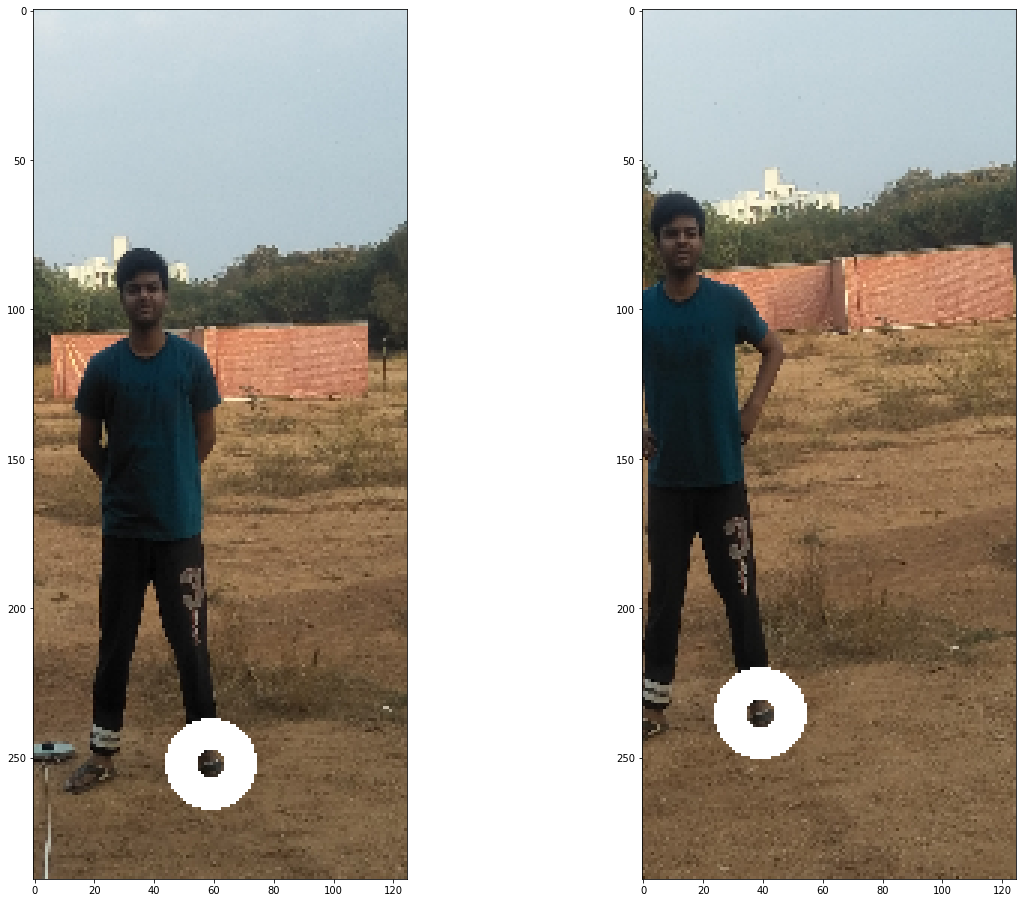

[(36.0, 228.0), (64.0, 239.0), (42.0, 181.20001220703125), (56.0, 233.0), (36.0, 77.0), (34.0, 237.0), (34.0, 232.0), (42.0, 181.0), (60.0, 235.0), (54.0, 176.0), (57.0, 239.0), (54.0, 186.0), (58.0, 237.0), (57.60000228881836, 236.40000915527344), (42.0, 80.4000015258789), (57.0, 99.0), (59.040000915527344, 92.16000366210938), (69.12000274658203, 96.4800033569336), (55.20000076293945, 229.20001220703125), (53.0, 179.0), (48.96000289916992, 203.04000854492188), (66.0, 112.80000305175781), (41.0, 85.0), (40.80000305175781, 91.20000457763672), (69.0, 92.0), (77.0, 231.0), (47.52000045776367, 95.04000091552734), (65.0, 95.0), (53.5680046081543, 126.14401245117188), (63.60000228881836, 212.40000915527344), (52.0, 223.0), (55.20000076293945, 94.80000305175781), (54.000003814697266, 97.20000457763672), (34.0, 68.0), (60.480003356933594, 181.44000244140625), (43.20000076293945, 76.80000305175781), (55.20000076293945, 124.80000305175781), (78.0, 122.4000015258789), (64.80000305175781, 95.04000

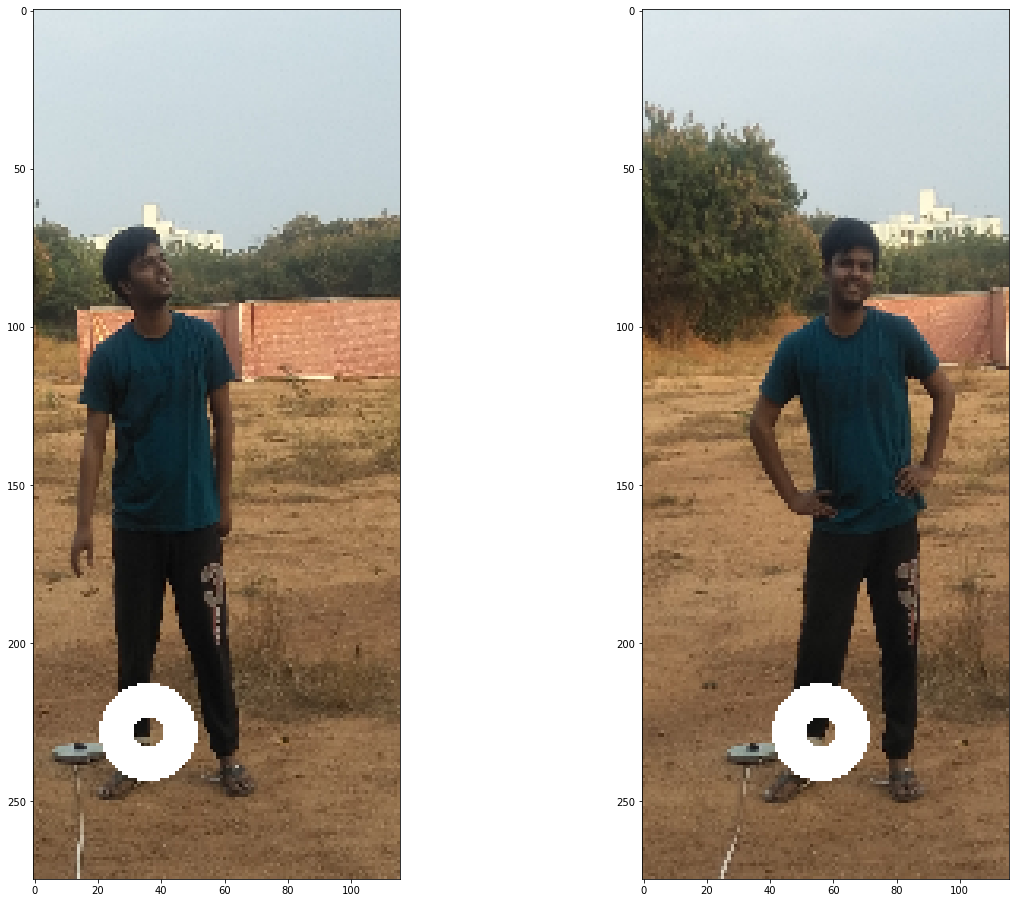

[(51.60000228881836, 171.60000610351562), (38.0, 220.0), (40.80000305175781, 223.20001220703125), (37.20000076293945, 228.00001525878906), (33.0, 150.0), (38.400001525878906, 219.60000610351562), (31.0, 140.0), (40.0, 231.0), (40.0, 227.0), (36.0, 198.0), (52.0, 174.0), (33.0, 154.0), (41.0, 224.0), (32.0, 224.0), (38.0, 228.0), (37.0, 235.0), (40.80000305175781, 234.00001525878906), (34.0, 227.0), (36.0, 245.0), (34.0, 220.0), (37.20000076293945, 231.60000610351562), (40.80000305175781, 226.8000030517578), (39.60000228881836, 229.20001220703125), (46.0, 221.0), (32.0, 119.0), (51.0, 63.0), (44.0, 239.0), (53.0, 50.0), (53.0, 59.0), (57.0, 60.0), (59.0, 209.0), (46.08000183105469, 218.8800048828125), (66.0, 191.0), (55.0, 63.0), (54.0, 66.0), (33.0, 244.0), (31.0, 77.0), (53.28000259399414, 50.400001525878906), (43.0, 224.0), (63.0, 234.0), (31.0, 79.0), (46.0, 230.0), (50.0, 215.0), (54.000003814697266, 189.60000610351562), (40.0, 50.0), (47.0, 226.0), (48.96000289916992, 47.520000457

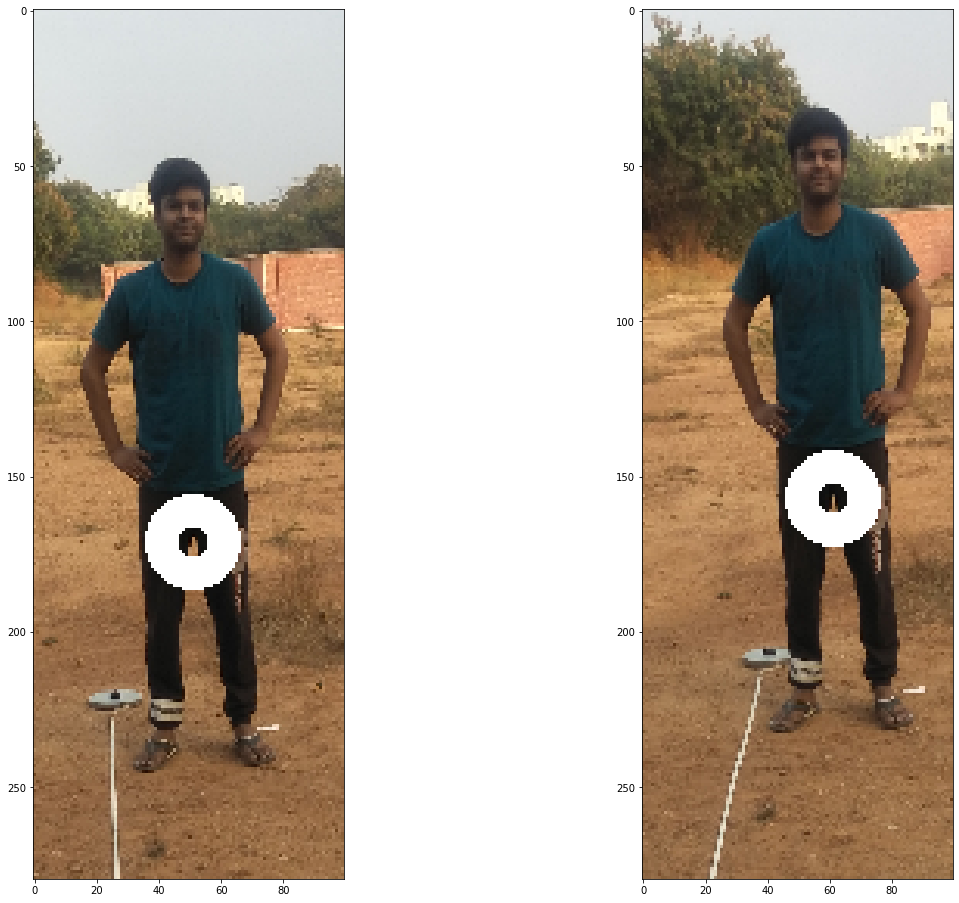

[(35.0, 193.0), (34.0, 201.0), (33.0, 174.0), (31.0, 140.0), (44.0, 45.0), (33.0, 47.0), (40.0, 44.0), (40.0, 221.0), (31.0, 49.0), (44.0, 36.0), (34.0, 41.0), (39.0, 219.0), (35.0, 49.0), (31.0, 116.0), (31.0, 129.0), (31.0, 215.0), (31.0, 38.0), (32.0, 126.0), (39.0, 228.0)]


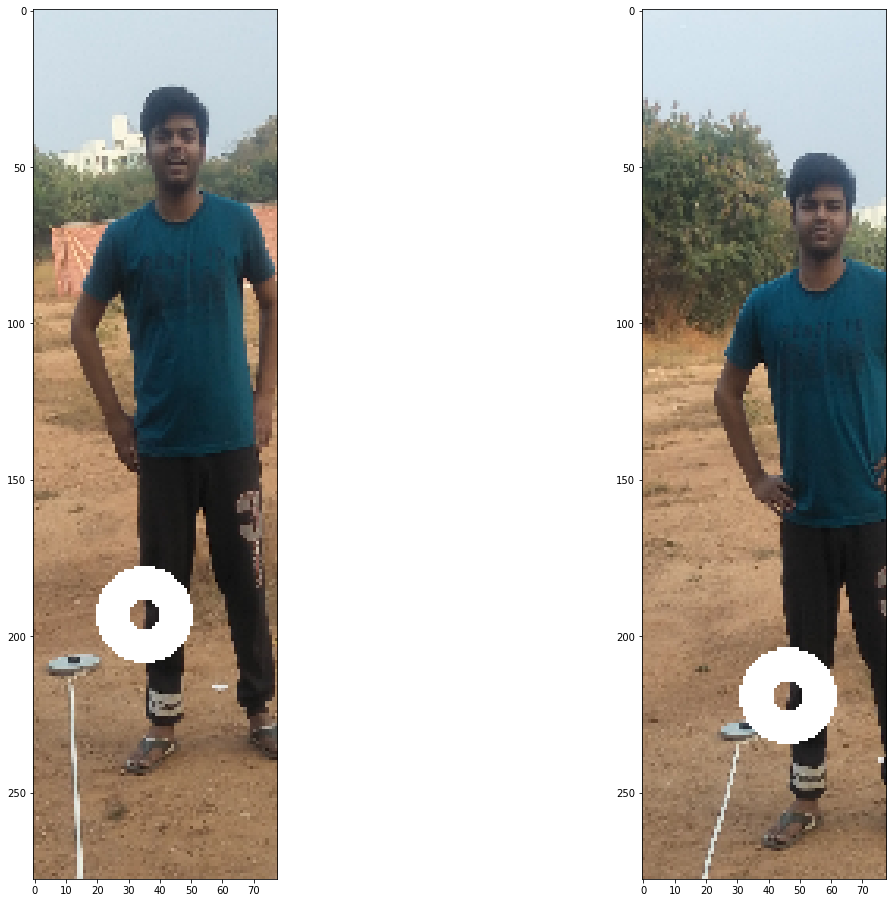

[(76.31999969482422, 252.00001525878906), (77.0, 110.0), (54.000003814697266, 250.8000030517578), (76.80000305175781, 252.00001525878906), (78.0, 106.80000305175781), (47.0, 247.0), (54.000003814697266, 240.00001525878906), (60.480003356933594, 185.760009765625), (83.0, 258.0), (53.0, 247.0), (81.0, 85.0), (75.60000610351562, 247.20001220703125), (54.0, 242.0), (60.000003814697266, 183.60000610351562), (46.0, 243.0), (81.0, 110.0), (75.0, 181.0), (75.60000610351562, 183.60000610351562), (76.0, 179.0), (82.80000305175781, 112.80000305175781), (72.0, 233.28001403808594), (77.0, 126.0), (82.80000305175781, 258.0), (81.60000610351562, 175.20001220703125), (79.20000457763672, 182.40000915527344), (86.0, 258.0), (78.0, 107.0), (79.0, 178.0), (57.60000228881836, 39.60000228881836), (74.4000015258789, 151.20001220703125), (60.0, 183.0), (84.0, 255.0), (81.60000610351562, 126.00000762939453), (77.0, 191.0), (46.0, 250.0), (80.4000015258789, 188.40000915527344), (73.0, 68.0), (48.0, 250.0), (79.

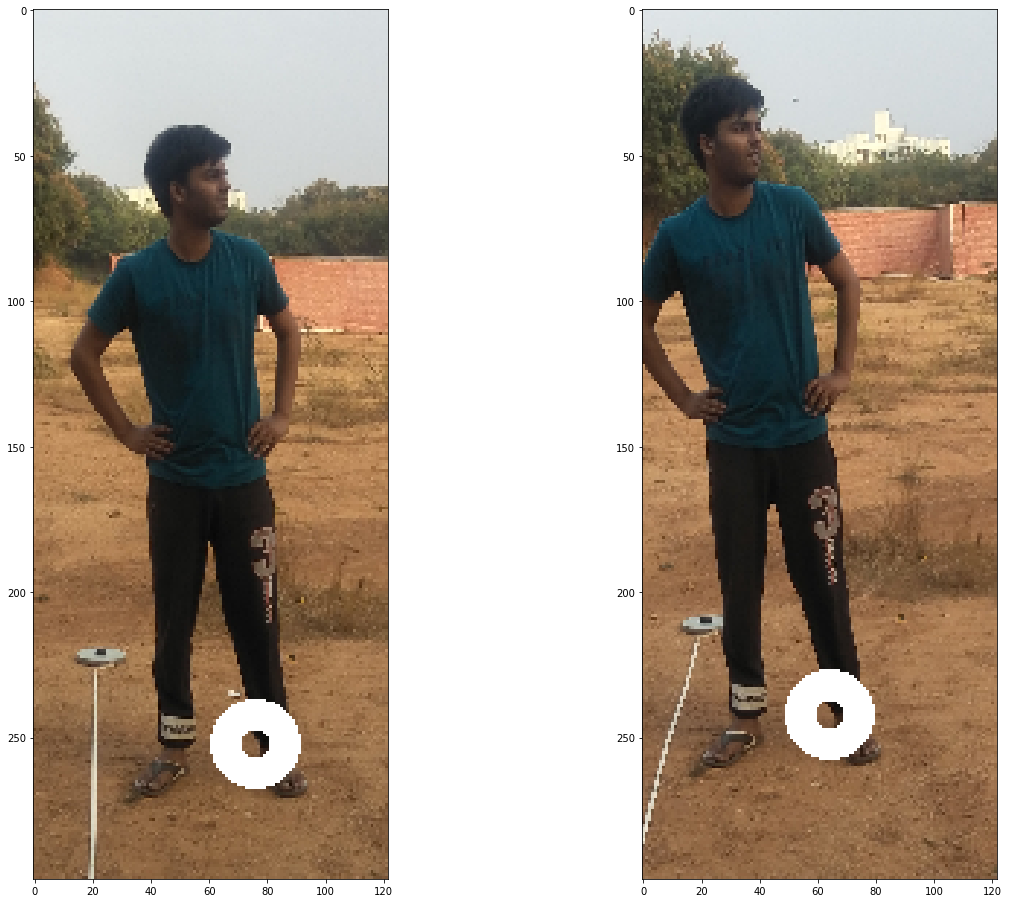

[(44.0, 240.0), (52.80000305175781, 236.40000915527344), (55.20000076293945, 228.00001525878906), (58.80000305175781, 210.00001525878906), (64.0, 177.0), (56.400001525878906, 210.00001525878906), (48.0, 237.0), (45.60000228881836, 237.60000610351562), (67.20000457763672, 37.20000076293945), (52.0, 242.0), (42.0, 151.0), (56.0, 211.0), (42.0, 234.00001525878906), (73.0, 35.0), (45.0, 244.0), (61.20000076293945, 188.40000915527344), (40.0, 96.0), (65.0, 41.0), (72.0, 240.0), (65.0, 39.0), (42.0, 230.40000915527344), (51.840003967285156, 236.16000366210938), (67.0, 36.0), (58.0, 207.0), (42.0, 103.0), (69.0, 203.0), (64.80000305175781, 40.80000305175781), (39.60000228881836, 98.4000015258789), (42.0, 147.60000610351562), (48.0, 241.20001220703125), (73.0, 49.0), (75.0, 55.0), (42.0, 143.0), (45.60000228881836, 138.0), (40.0, 98.0), (51.0, 57.0), (60.0, 195.0), (42.0, 132.0), (37.20000076293945, 133.20001220703125), (62.400001525878906, 43.20000076293945), (37.20000076293945, 104.400001525

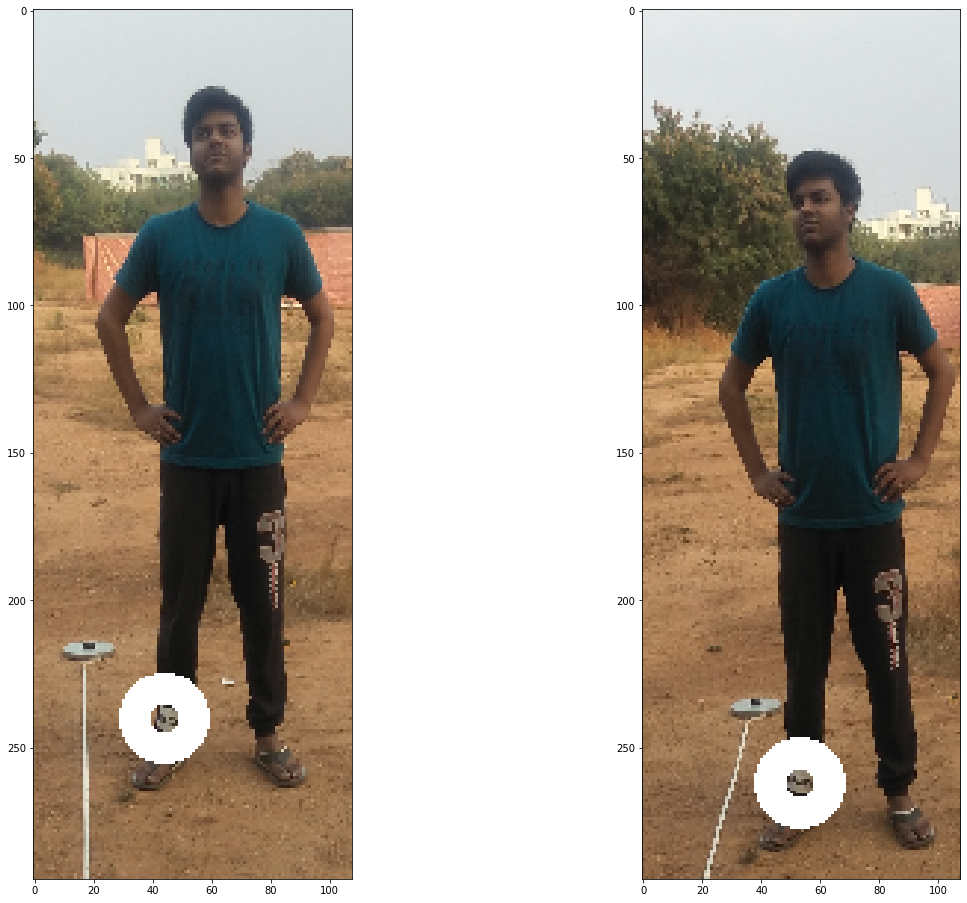

[(47.52000045776367, 84.96000671386719), (48.0, 84.0), (35.0, 307.0), (31.0, 300.0), (39.0, 311.0), (38.0, 325.0), (48.96000289916992, 239.04000854492188), (49.0, 102.0), (33.0, 301.0), (38.400001525878906, 300.0), (50.400001525878906, 97.20000457763672), (48.0, 102.00000762939453), (56.0, 93.0), (51.0, 98.0), (55.0, 116.0), (61.0, 303.0), (40.0, 302.0), (39.60000228881836, 302.4000244140625), (40.0, 308.0), (48.0, 106.0), (38.0, 314.0), (52.80000305175781, 266.4000244140625), (55.0, 269.0), (46.80000305175781, 105.60000610351562), (54.0, 105.0), (53.0, 118.0), (55.20000076293945, 268.8000183105469), (39.60000228881836, 310.8000183105469), (64.80000305175781, 108.00000762939453), (50.400001525878906, 253.20001220703125), (33.0, 332.0), (54.000003814697266, 100.80000305175781), (63.0, 314.0), (51.60000228881836, 261.6000061035156), (56.0, 110.0), (55.0, 101.0), (58.0, 296.0), (39.60000228881836, 307.20001220703125), (62.0, 235.0), (48.0, 238.8000030517578), (50.400001525878906, 253.4400

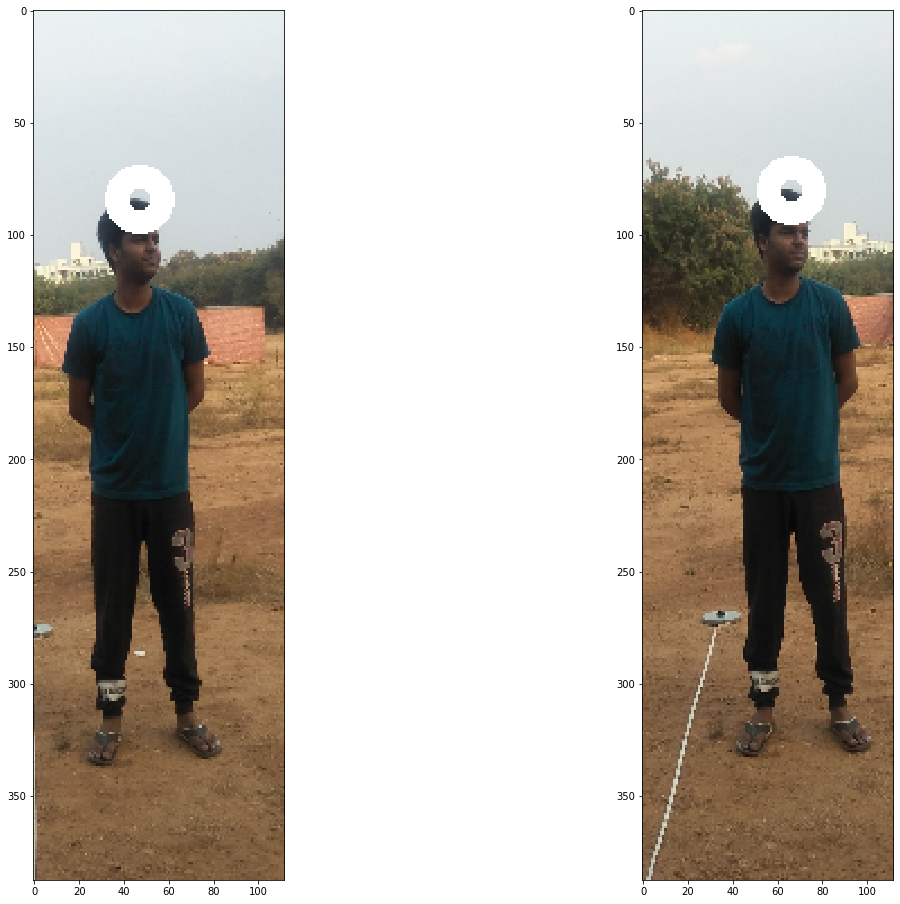

[(51.0, 219.0), (33.0, 177.0), (51.60000228881836, 219.60000610351562), (35.0, 78.0), (50.0, 215.0), (45.0, 224.0), (42.0, 214.8000030517578), (41.0, 223.0), (31.0, 230.0), (55.0, 197.0), (55.0, 200.0), (51.0, 232.0), (34.0, 93.0), (39.0, 124.0), (36.0, 240.0), (51.60000228881836, 224.40000915527344), (36.0, 72.0), (38.0, 76.0), (49.0, 231.0), (39.0, 163.0), (44.0, 231.0), (32.0, 71.0), (38.0, 177.0), (35.0, 229.0), (34.0, 40.0), (38.400001525878906, 103.20000457763672), (42.0, 231.0), (50.0, 33.0)]


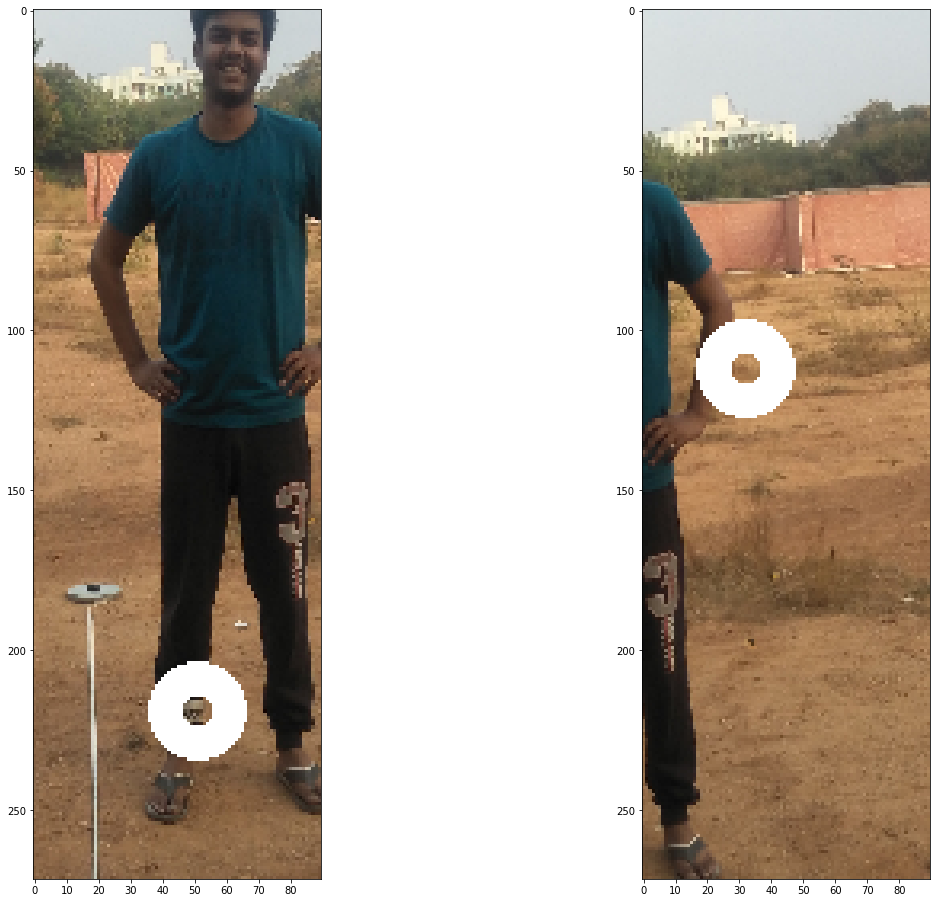

[(117.0, 36.0), (122.0, 33.0), (120.0, 34.0), (126.0, 93.0), (131.0, 153.0), (115.0, 33.0), (108.0, 38.0), (97.92000579833984, 56.160003662109375), (130.0, 285.0), (43.20000076293945, 202.8000030517578), (112.0, 38.0), (130.0, 259.0), (108.00000762939453, 38.400001525878906), (37.0, 140.0), (90.0, 144.0), (93.0, 31.0), (97.0, 31.0), (110.0, 37.0), (131.0, 130.0), (38.0, 145.0), (123.0, 301.0), (127.0, 148.0), (37.0, 138.0), (124.0, 129.0), (106.0, 35.0), (131.0, 302.0), (82.80000305175781, 60.000003814697266), (95.04000091552734, 205.92001342773438), (44.0, 106.0), (93.60000610351562, 117.60000610351562), (132.0, 287.0), (127.0, 238.0), (100.80000305175781, 96.4800033569336), (128.0, 33.0), (35.0, 138.0), (122.4000015258789, 63.60000228881836), (113.76000213623047, 102.24000549316406), (80.4000015258789, 112.80000305175781), (76.80000305175781, 96.0), (124.80000305175781, 103.20000457763672), (117.60000610351562, 52.80000305175781), (103.20000457763672, 148.8000030517578), (72.0, 57.60

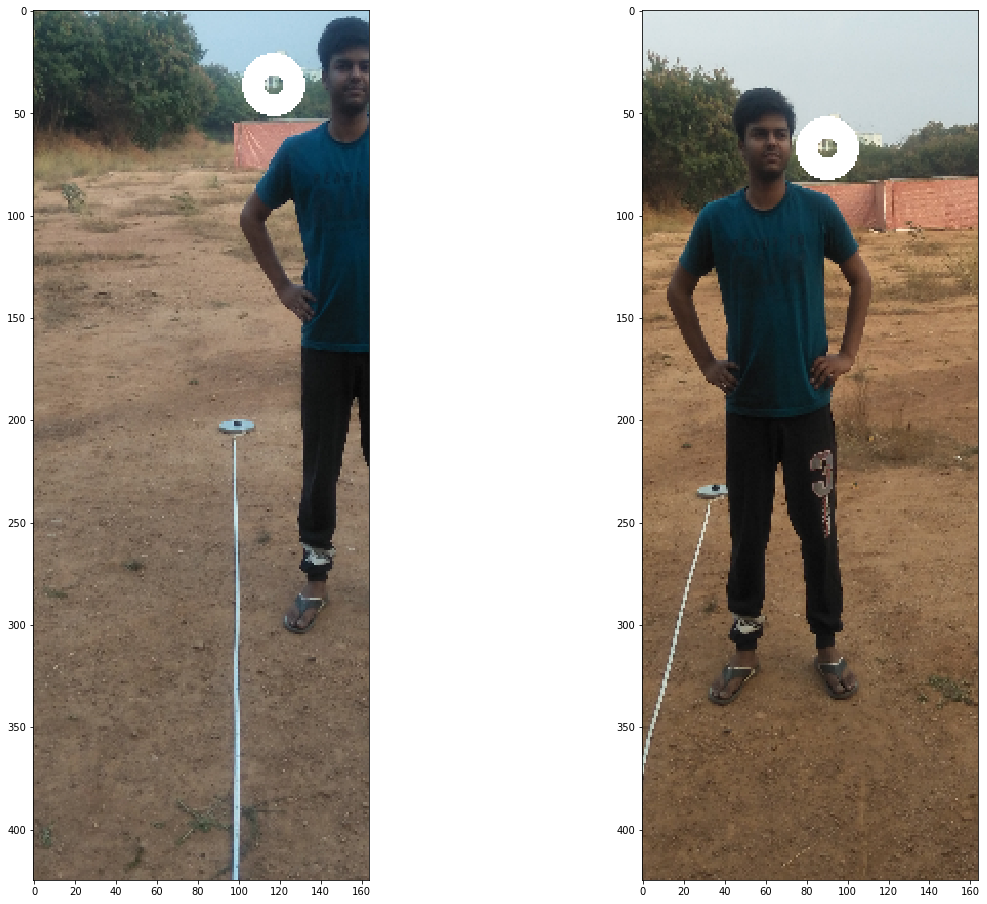

[(61.0, 38.0), (48.0, 52.80000305175781), (56.160003662109375, 119.52000427246094), (51.60000228881836, 147.60000610351562), (46.0, 32.0), (64.0, 274.0), (54.0, 32.0), (59.040000915527344, 59.040000915527344), (66.0, 57.0), (43.20000076293945, 216.00001525878906), (63.0, 74.0), (56.400001525878906, 200.40000915527344), (56.0, 201.0), (61.0, 70.0), (63.60000228881836, 232.8000030517578), (68.0, 40.0), (73.0, 41.0), (49.0, 68.0), (75.0, 81.0), (44.400001525878906, 64.80000305175781), (62.0, 54.0), (44.0, 80.0), (51.0, 91.0), (59.0, 34.0), (36.0, 31.0), (56.0, 34.0), (60.0, 224.0), (49.20000076293945, 45.60000228881836), (61.20000076293945, 69.60000610351562), (62.0, 204.0), (58.0, 68.0), (39.0, 81.0), (77.0, 85.0), (31.0, 45.0), (67.20000457763672, 39.60000228881836), (66.0, 67.20000457763672), (42.0, 180.0), (69.60000610351562, 357.6000061035156), (36.0, 83.0), (62.0, 78.0), (60.000003814697266, 64.80000305175781), (75.0, 33.0), (53.0, 252.0), (47.0, 293.0), (67.20000457763672, 372.0), 

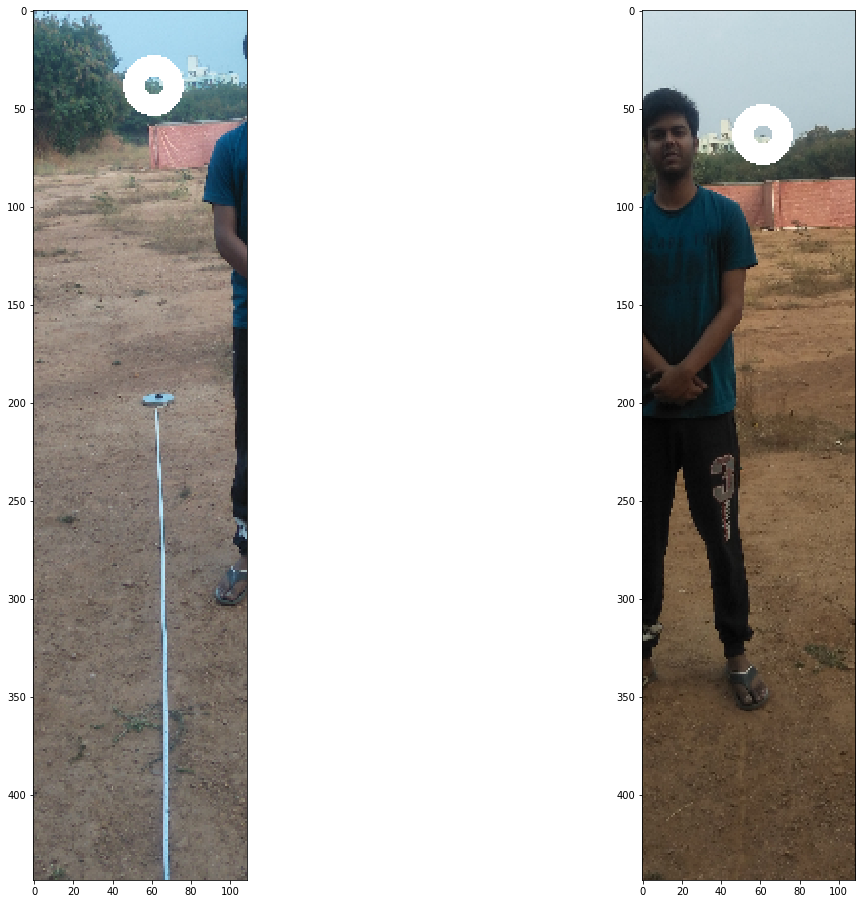

[(61.20000076293945, 39.60000228881836), (87.84000396728516, 70.56000518798828), (80.0, 72.0), (57.02400588989258, 222.91201782226562), (104.0, 95.0), (85.20000457763672, 264.0), (76.0, 402.0), (78.0, 133.0), (54.0, 114.0), (88.80000305175781, 54.000003814697266), (82.80000305175781, 70.80000305175781), (81.60000610351562, 91.20000457763672), (74.8800048828125, 47.52000045776367), (42.0, 157.0), (91.20000457763672, 55.20000076293945), (79.20000457763672, 133.9199981689453), (57.60000228881836, 114.00000762939453), (95.0, 50.0), (109.0, 50.0), (96.4800033569336, 69.12000274658203), (93.0, 53.0), (83.0, 87.0), (93.60000610351562, 52.80000305175781), (92.0, 55.0), (112.0, 48.0), (70.80000305175781, 100.80000305175781), (78.0, 82.0), (82.08000183105469, 90.72000122070312), (83.0, 47.0), (76.80000305175781, 219.60000610351562), (56.160003662109375, 106.56000518798828), (104.0, 52.0), (115.0, 45.0), (87.84000396728516, 391.6800231933594), (72.57601165771484, 80.87041473388672), (99.600006103

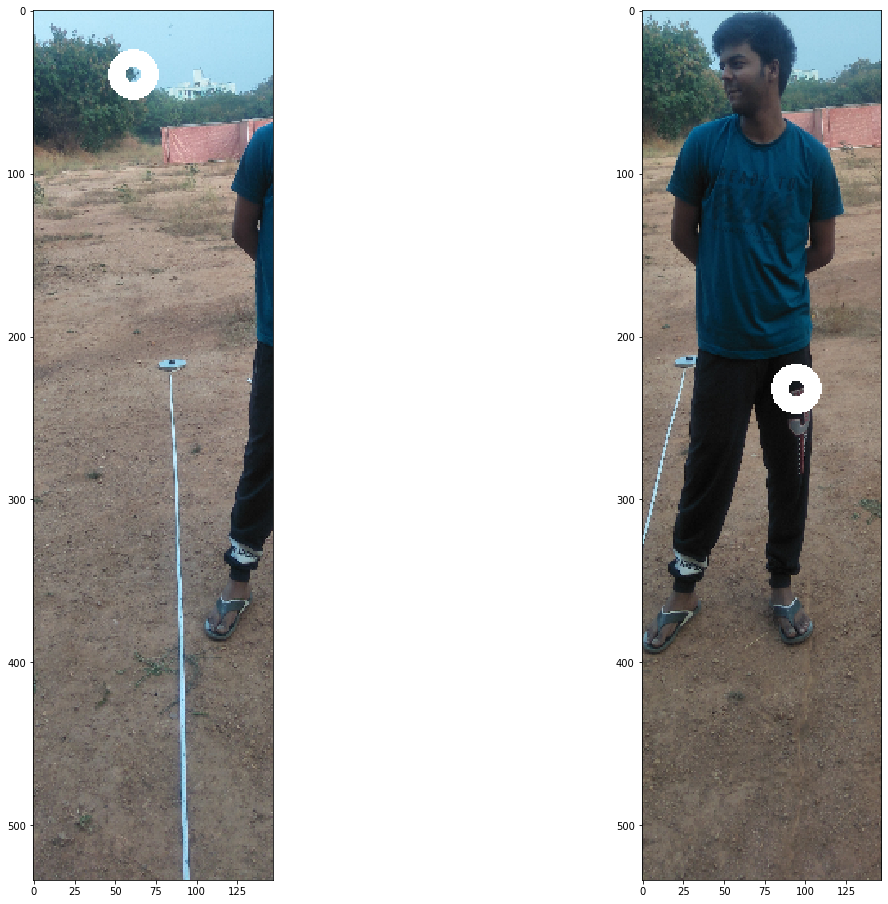

[(85.20000457763672, 74.4000015258789), (70.84800720214844, 57.02400588989258), (127.0, 88.0), (73.44000244140625, 53.28000259399414), (118.0, 86.0), (66.0, 55.20000076293945), (100.80000305175781, 85.20000457763672), (116.0, 90.0), (60.480003356933594, 50.400001525878906), (44.6400032043457, 51.840003967285156), (122.0, 89.0), (115.20000457763672, 90.0), (44.400001525878906, 231.60000610351562), (121.20000457763672, 88.80000305175781), (90.0, 80.4000015258789), (86.4000015258789, 79.20000457763672), (93.31201171875, 80.87041473388672), (102.0, 108.0), (49.20000076293945, 48.0), (63.60000228881836, 57.60000228881836), (84.0, 79.20000457763672), (44.6400032043457, 231.8400115966797), (49.0, 49.0), (35.0, 53.0), (123.0, 81.0), (112.0, 91.0), (113.0, 87.0), (122.0, 306.0), (111.60000610351562, 91.20000457763672), (32.0, 54.0), (108.00000762939453, 148.8000030517578), (56.0, 56.0), (65.0, 58.0), (96.76800537109375, 115.77600860595703), (58.0, 55.0), (110.0, 147.0), (66.0, 195.0), (109.4400

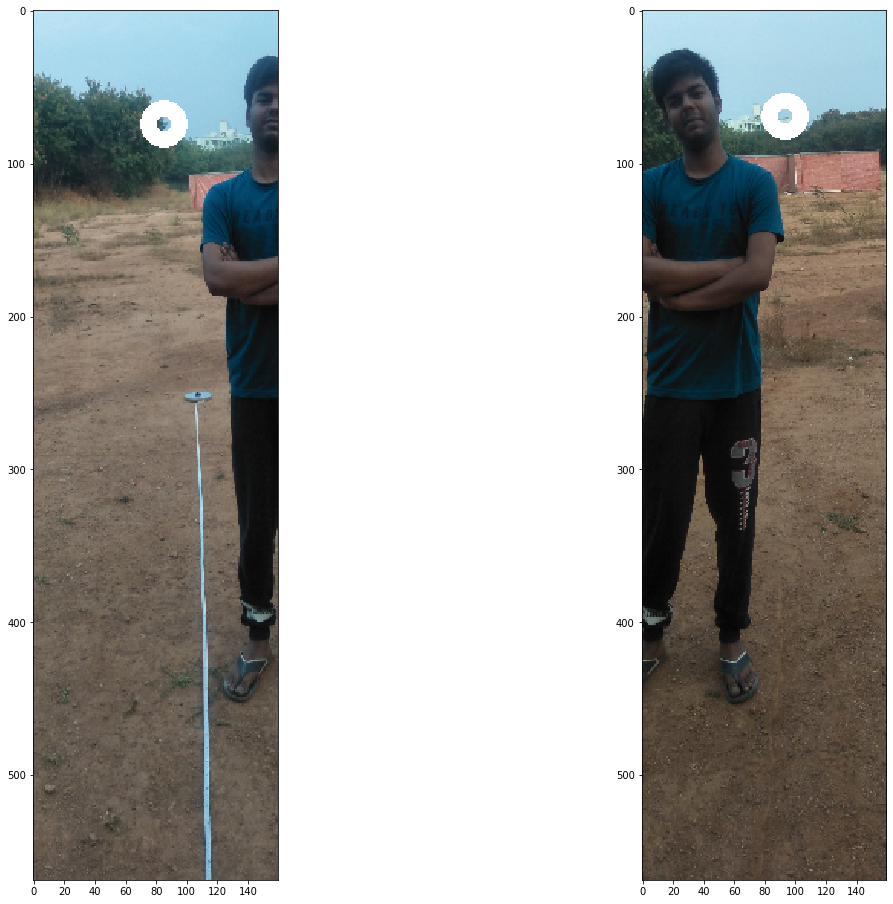

[(116.0, 53.0), (109.0, 53.0), (106.0, 52.0), (106.80000305175781, 51.60000228881836), (100.0, 50.0), (112.0, 50.0), (98.0, 54.0), (103.20000457763672, 96.0), (115.0, 55.0), (110.4000015258789, 72.0), (93.60000610351562, 144.0), (65.66400909423828, 114.04801177978516), (63.0, 49.0), (80.0, 67.0), (78.79681396484375, 161.74082946777344), (96.0, 189.60000610351562), (57.60000228881836, 44.6400032043457), (89.2800064086914, 46.08000183105469), (100.80000305175781, 93.60000610351562), (80.63999938964844, 158.40000915527344), (73.0, 72.0), (69.0, 191.0), (81.21601104736328, 150.3360137939453), (66.35520935058594, 103.68001556396484), (92.0, 52.0), (68.0, 102.0), (67.0, 187.0), (66.0, 128.40000915527344), (55.0, 38.0), (63.0, 206.0), (93.0, 54.0), (62.400001525878906, 205.20001220703125), (62.2080078125, 84.67200469970703), (64.80000305175781, 136.8000030517578), (93.60000610351562, 54.000003814697266), (80.4000015258789, 152.40000915527344), (69.12001037597656, 72.57600402832031), (55.29600

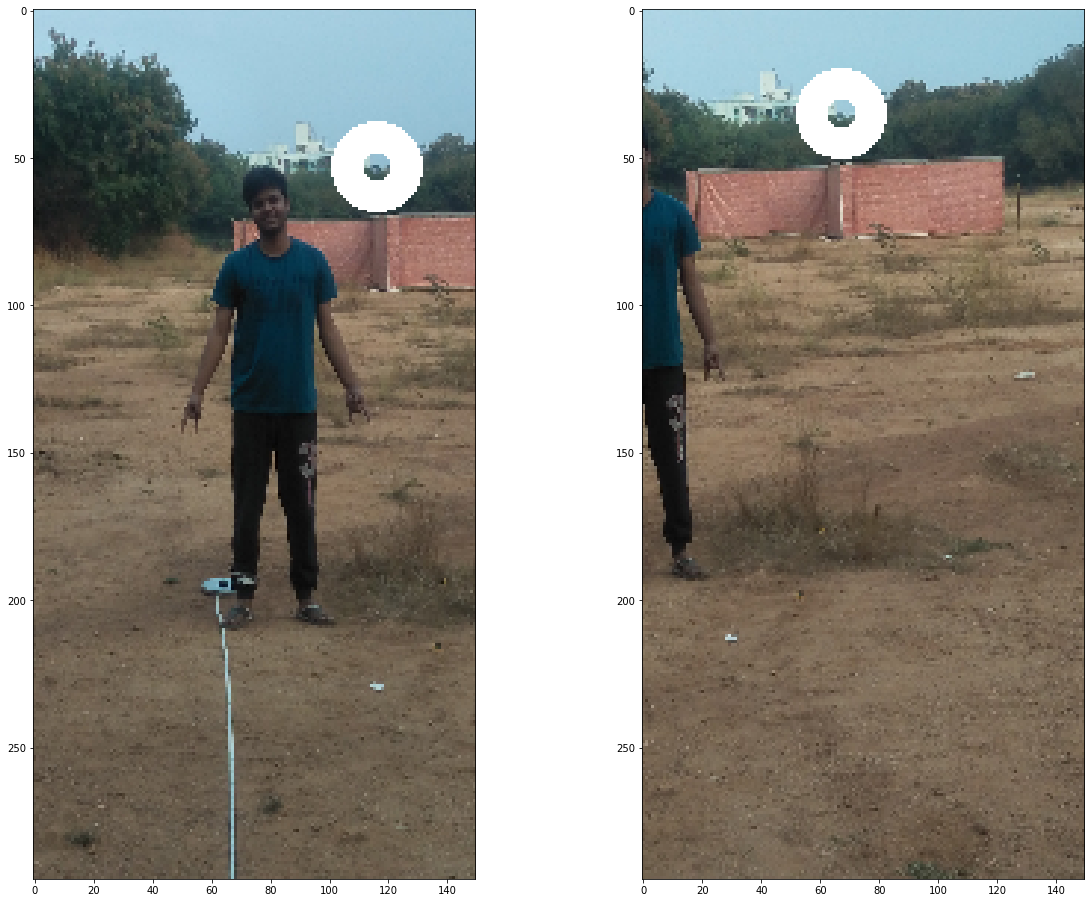

[(81.0, 132.0), (66.0, 66.0), (61.0, 66.0), (61.20000076293945, 66.0), (72.0, 63.0), (68.0, 85.0), (81.0, 229.0), (63.0, 83.0), (68.0, 89.0), (70.80000305175781, 63.60000228881836), (75.60000610351562, 81.60000610351562), (70.0, 65.0), (57.60000228881836, 66.0), (66.0, 82.80000305175781), (75.0, 60.0), (76.80000305175781, 60.000003814697266), (57.0, 63.0), (59.0, 66.0), (64.0, 85.0), (79.0, 58.0), (83.0, 55.0), (36.0, 54.0), (56.400001525878906, 122.4000015258789), (78.0, 106.0), (56.160003662109375, 155.52000427246094), (36.0, 57.0), (54.000003814697266, 60.000003814697266), (76.80000305175781, 124.80000305175781), (56.0, 167.0), (33.0, 73.0), (55.0, 92.0), (77.0, 113.0), (36.0, 63.0), (55.0, 232.0), (58.0, 118.0), (40.0, 68.0), (42.0, 227.0), (59.0, 129.0), (59.0, 158.0), (67.20000457763672, 178.8000030517578), (42.0, 59.0), (53.5680046081543, 160.70401000976562), (56.0, 220.0), (63.60000228881836, 82.80000305175781), (76.80000305175781, 158.40000915527344), (59.040000915527344, 110.

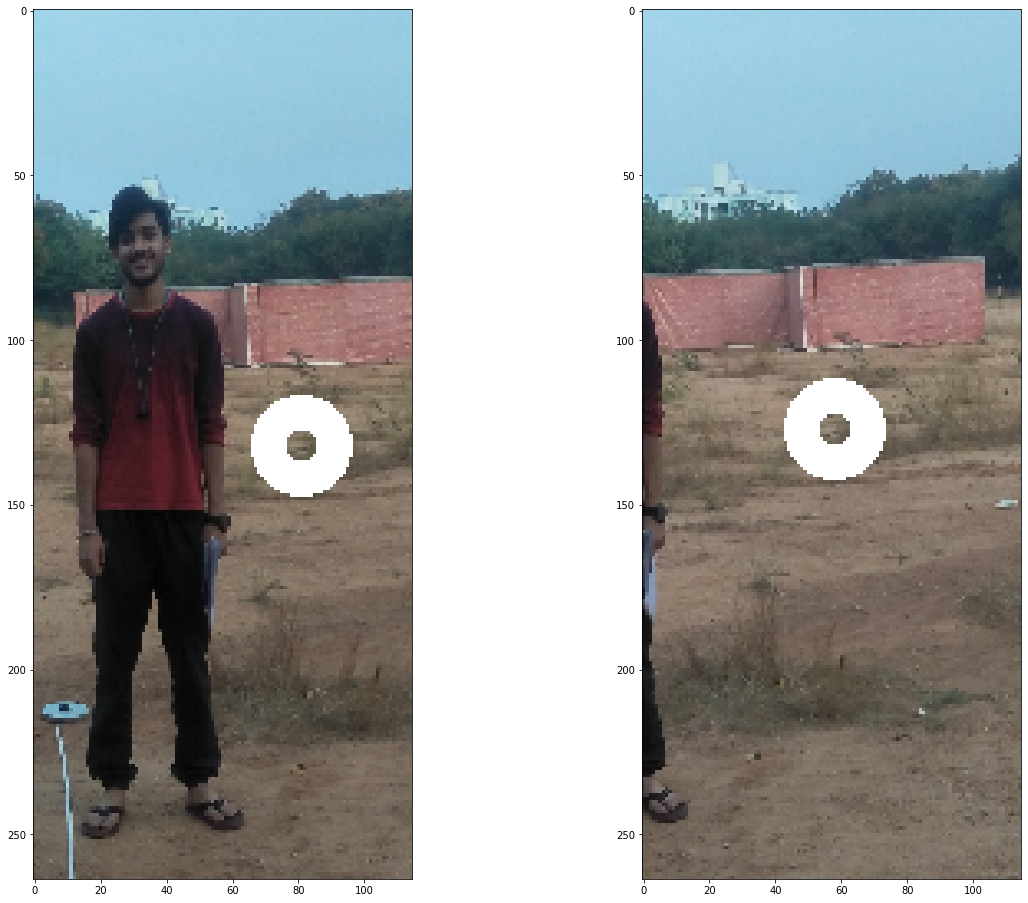

[(41.0, 265.0), (38.0, 247.0), (38.0, 56.0), (34.0, 206.0), (39.0, 67.0), (32.0, 186.0), (36.0, 68.0), (34.0, 116.0), (31.0, 53.0), (42.0, 79.0), (33.0, 47.0), (35.0, 223.0), (34.0, 52.0), (34.0, 113.0)]


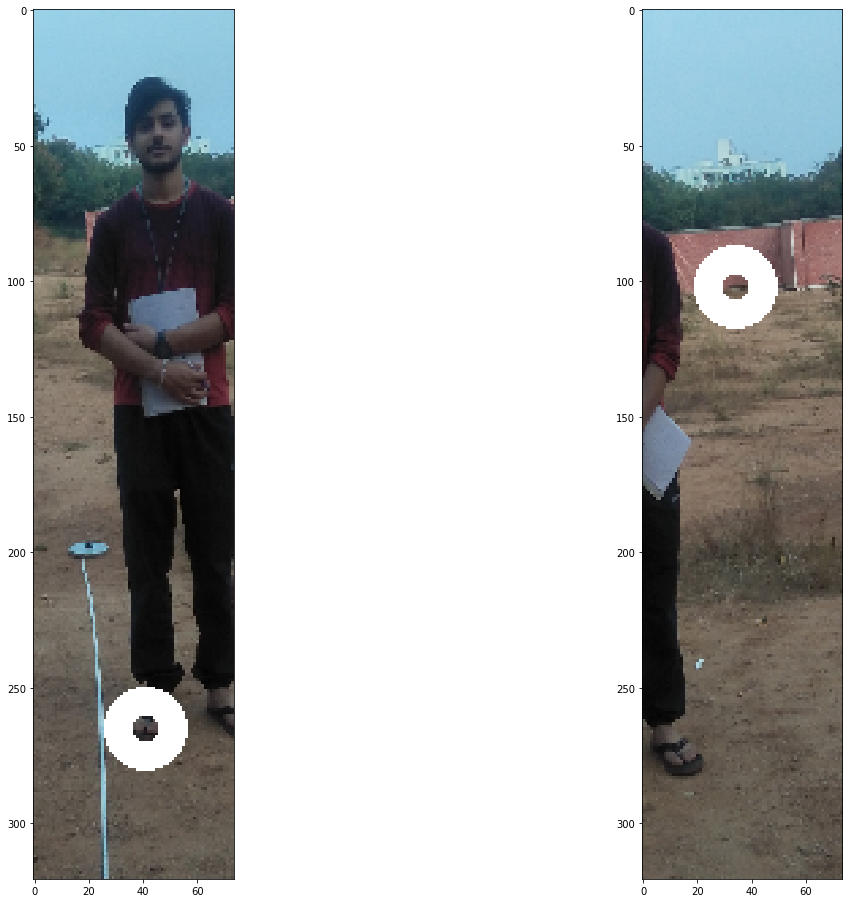

[(97.20000457763672, 82.80000305175781), (95.0, 86.0), (103.0, 80.0), (80.4000015258789, 78.0), (59.040000915527344, 48.96000289916992), (86.40000915527344, 107.1360092163086), (68.4000015258789, 69.60000610351562), (101.0, 239.0), (58.80000305175781, 52.80000305175781), (52.0, 51.0), (70.56000518798828, 74.8800048828125), (103.0, 83.0), (85.0, 104.0), (99.36000061035156, 214.5600128173828), (70.80000305175781, 76.80000305175781), (82.80000305175781, 79.20000457763672), (95.04000091552734, 155.52000427246094), (104.4000015258789, 86.4000015258789), (108.00000762939453, 214.8000030517578), (83.52000427246094, 472.32000732421875), (102.0, 243.0), (102.0, 109.0), (51.60000228881836, 49.20000076293945), (111.60000610351562, 73.20000457763672), (65.66400909423828, 229.8240203857422), (118.0, 83.0), (84.0, 336.0), (93.60000610351562, 136.8000030517578), (99.0, 235.0), (99.60000610351562, 86.4000015258789), (93.31201171875, 148.60801696777344), (99.0, 177.0), (94.80000305175781, 135.600006103

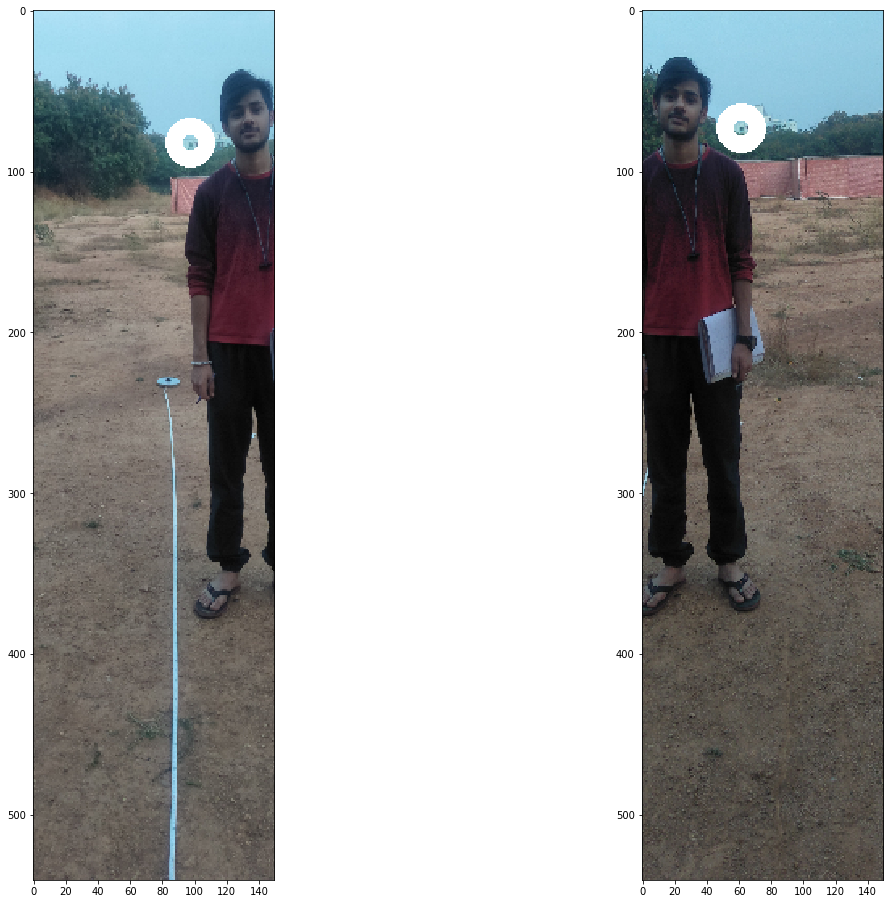

[(49.20000076293945, 75.60000610351562), (172.10882568359375, 400.2048645019531), (51.0, 76.0), (165.88803100585938, 410.5728454589844), (42.0, 72.0), (33.0, 66.0), (174.24000549316406, 400.32000732421875), (48.96000289916992, 76.31999969482422), (49.0, 76.0), (55.0, 83.0), (45.0, 71.0), (45.60000228881836, 74.4000015258789), (181.4400177001953, 321.40802001953125), (196.8000030517578, 72.0), (55.20000076293945, 82.80000305175781), (176.25601196289062, 62.2080078125), (149.29922485351562, 402.2784423828125), (180.0, 62.0), (136.0, 120.0), (37.0, 69.0), (59.0, 81.0), (35.0, 68.0), (196.0, 71.0), (172.80001831054688, 402.6240234375), (153.44642639160156, 429.2352600097656), (134.0, 119.0), (174.0, 403.20001220703125), (155.52001953125, 425.0880432128906), (156.76419067382812, 423.0144958496094), (59.0, 83.0), (96.0, 81.60000610351562), (46.0, 75.0), (140.0, 122.0), (154.8000030517578, 406.8000183105469), (152.0, 405.0), (135.60000610351562, 120.00000762939453), (103.68000793457031, 86.40

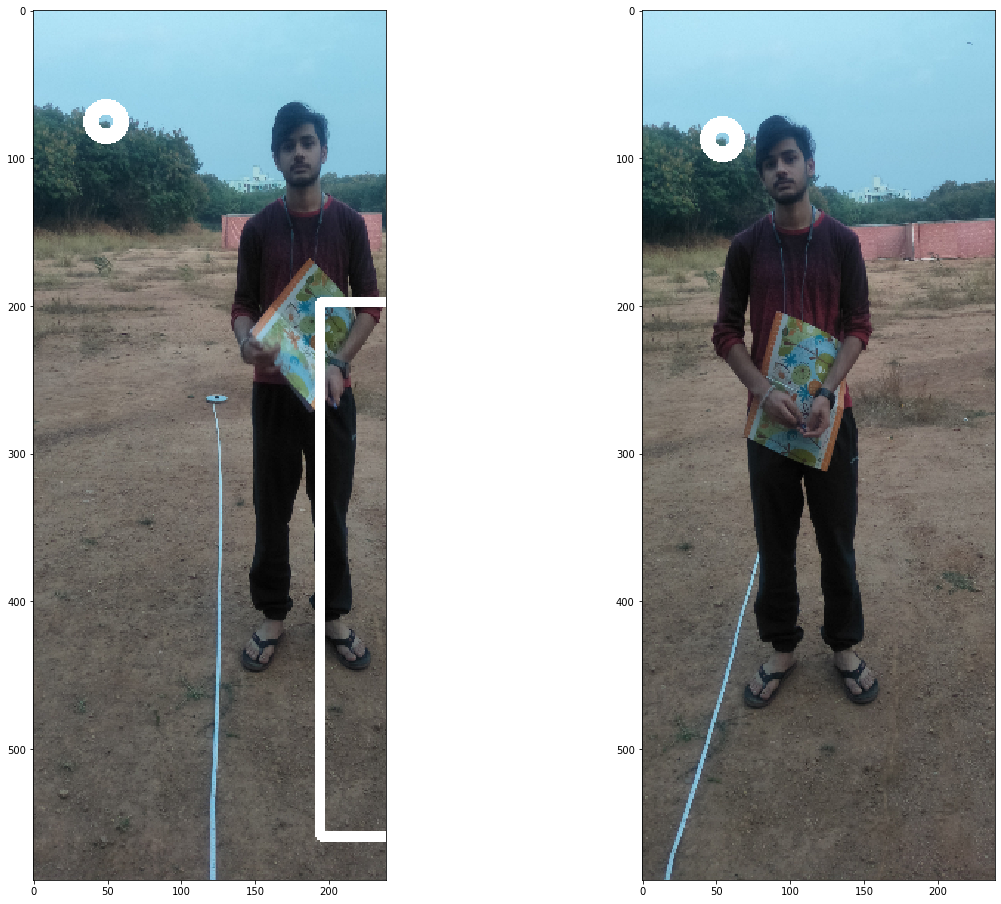

[(123.60000610351562, 186.0), (131.0, 187.0), (199.0, 127.0), (199.0656280517578, 128.56321716308594), (172.10882568359375, 116.12161254882812), (165.88803100585938, 120.26881408691406), (191.60069274902344, 430.4794616699219), (123.84000396728516, 181.44000244140625), (199.20001220703125, 127.20000457763672), (124.80000305175781, 181.20001220703125), (175.20001220703125, 115.20000457763672), (186.62403869628906, 520.0590209960938), (116.0, 167.0), (175.6800079345703, 115.20000457763672), (118.08000183105469, 169.92001342773438), (222.91201782226562, 362.8800354003906), (131.04000854492188, 187.20001220703125), (174.52801513671875, 115.77600860595703), (203.21282958984375, 369.1008605957031), (115.20000457763672, 166.8000030517578), (178.5600128173828, 116.64000701904297), (190.77122497558594, 526.6944580078125), (194.08901977539062, 432.9678039550781), (35.0, 152.0), (122.6880111694336, 179.71202087402344), (110.4000015258789, 159.60000610351562), (201.60000610351562, 132.480010986328

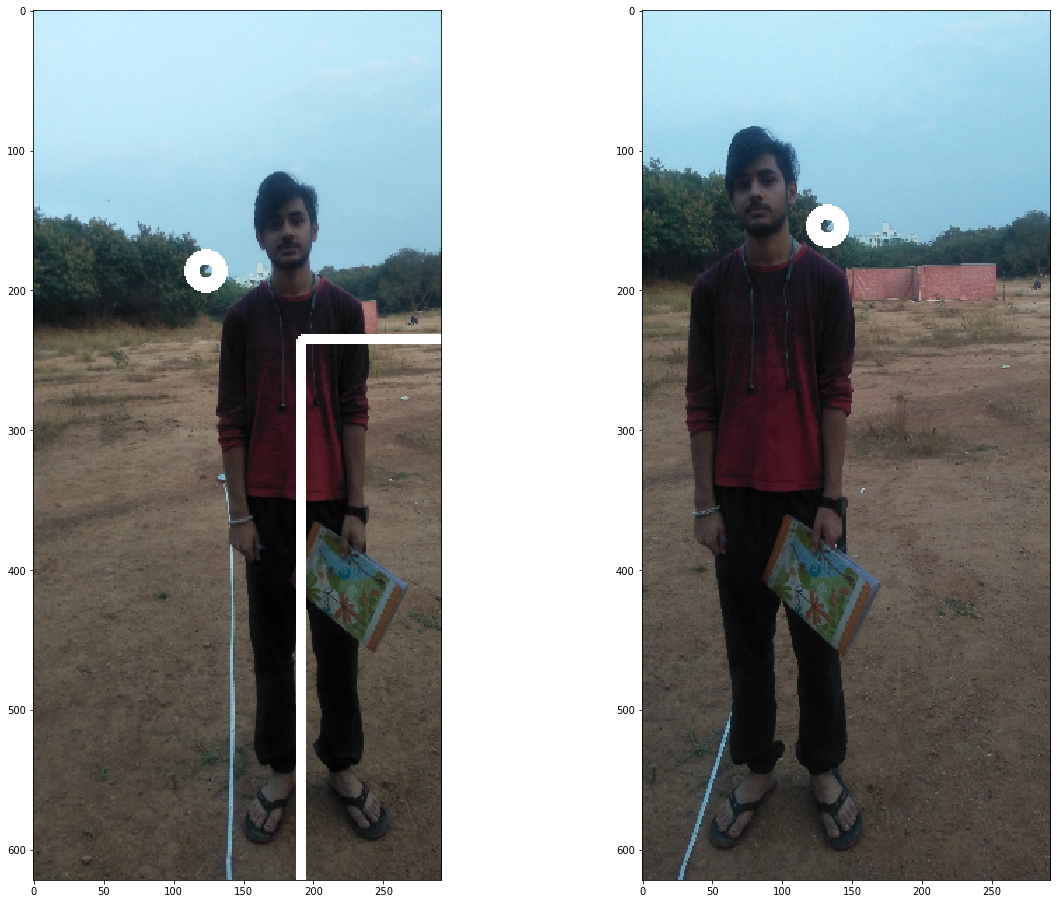

In [10]:
disparity = []

l = int(len(files)/2)
a = time.time()
for i in range(l):
    depth(i)
b = time.time()

In [11]:
seconds = b-a
seconds

26.527800798416138

In [12]:
fps = len(files)/seconds
fps

1.507852094636817

In [13]:
aD = pd.read_csv("/home/aman/Documents/Project/DepthCal/Data/data/distance1.csv", header = None)
actualDistance = aD[0]
actualDistance

0     5.00
1     5.00
2     4.75
3     4.50
4     4.25
5     4.00
6     4.00
7     3.75
8     3.50
9     3.25
10    3.00
11    2.50
12    2.25
13    6.00
14    5.50
15    5.00
16    4.00
17    3.00
18    2.50
19    2.00
Name: 0, dtype: float64

In [14]:
disparity

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [15]:
len(aD)

20

In [16]:
len(disparity)

20

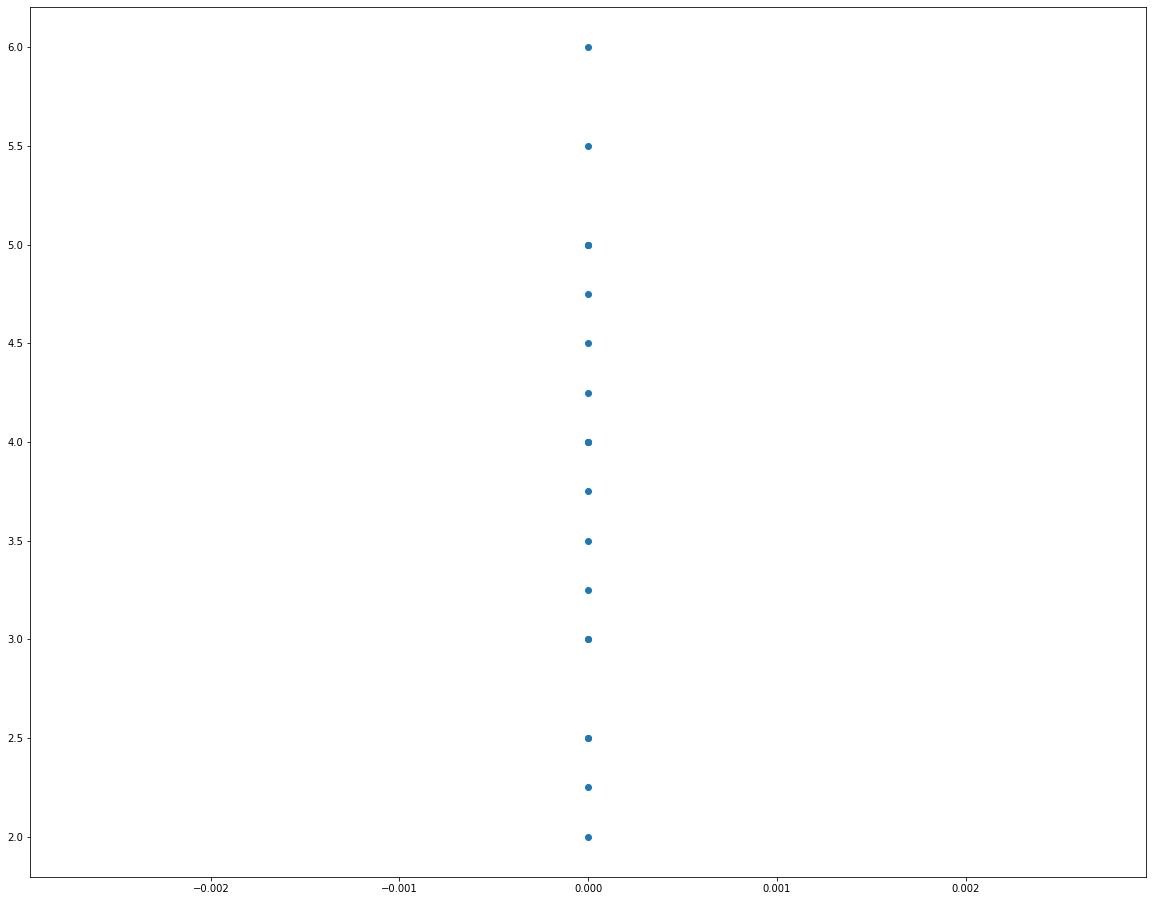

In [17]:
plt.figure(figsize = (20,16))
plt.scatter(disparity, actualDistance)
plt.show()

In [18]:
for i in range(l):
    print("Frame " + str(i) + " : " + str(disparity[i]) + " : " + str(actualDistance[i]))

Frame 0 : 0 : 5.0
Frame 1 : 0 : 5.0
Frame 2 : 0 : 4.75
Frame 3 : 0 : 4.5
Frame 4 : 0 : 4.25
Frame 5 : 0 : 4.0
Frame 6 : 0 : 4.0
Frame 7 : 0 : 3.75
Frame 8 : 0 : 3.5
Frame 9 : 0 : 3.25
Frame 10 : 0 : 3.0
Frame 11 : 0 : 2.5
Frame 12 : 0 : 2.25
Frame 13 : 0 : 6.0
Frame 14 : 0 : 5.5
Frame 15 : 0 : 5.0
Frame 16 : 0 : 4.0
Frame 17 : 0 : 3.0
Frame 18 : 0 : 2.5
Frame 19 : 0 : 2.0
